# Analysis of Antarctic Ice Sheet Extension: Annual Maxima and Minima

The extent of Antarctic Ice Sheet (AIS) serves as a critical indicator for understanding climate change dynamics and marine ecosystem shifts in one of the Earth’s most remote regions. The extent of Antarctic Ice Sheet is usually a re-analysis product. All the data is available in the OCEAN:ICE backend data tools.  

This notebook processes and presents the annual minimum and maximum extent of the AIS.
The tool uses the following products:

- Copernicus Marine Service
- OCEAN:ICE geoserver (https://geoserver.s4oceanice.eu/geoserver/ the ID is: ice_edge_nh_annual)

In [ ]:
# @title
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# @title
%%capture
!pip install ipywidgets==7.1.0 requests==2.31.0 ipyleaflet==0.18.1
%reload_ext autoreload
%autoreload 2

In [ ]:
# @title
'''This block of code gets a list of geojsons containing informations about the antarctic ice sheet by year.
The function reduceFun creates a dictionary with the data needed for the following cells of code'''
from functools import reduce
import requests
import json

resp = requests.get('https://geoserver.s4oceanice.eu/geoserver/oceanice/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oceanice%3AEMODnet_ice_edge_sh_annual&outputFormat=application%2Fjson&srsName=epsg:4326')

iceJson = resp.content
iceData = json.loads(iceJson)

def reduceFun(a, c):
  if c['properties']['year'] not in a.keys():
    a[c['properties']['year']] = {'type': "FeatureCollection", 'features':[]}
  a[c['properties']['year']]['features'].append(c)

  return a

iceDict = reduce(reduceFun, iceData['features'], {})

In the subsequent code cell, we calculate and visualize the minimum and maximum areas of the Antarctic ice sheet are calculated and visualized across various years. For each year, polygons representing ice sheet extent are processed and their areas are calculated after ensuring geometries are valid. The resulting minimum and maximum areas are plotted as bars, facilitating a comparative analysis of ice sheet fluctuations over time.  
  
Note: Some of the data may be missing so the values have to be considered as minimum limits.

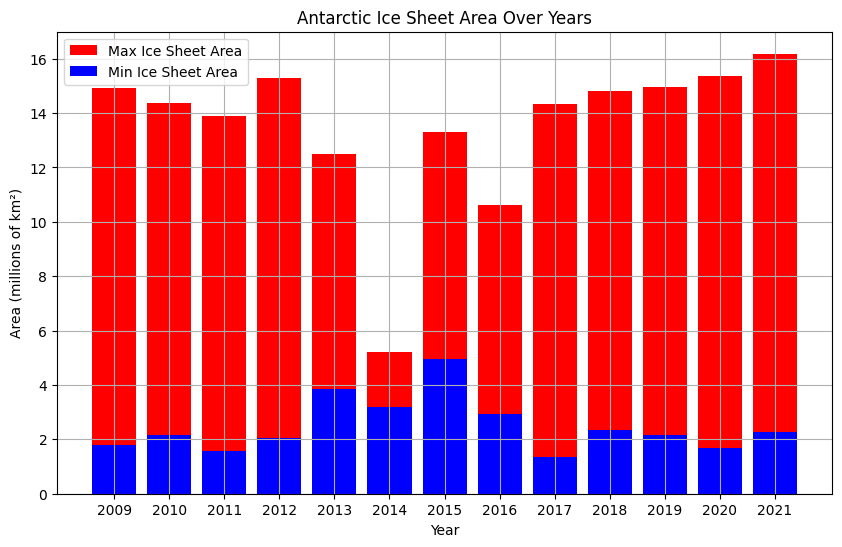

In [ ]:
# @title
import geopandas as gpd
from pyproj import Geod, Proj
from shapely.geometry import shape
import matplotlib.pyplot as plt

min_areas = {}
max_areas = {}

geod = Geod('+a=6378137 +f=0.0033528106647475126')

# Loop through each year in the iceDict
for year, data in iceDict.items():
    min_polygons = []
    max_polygons = []

    # Separate geometries into minima and maxima
    for feature in data['features']:
        geom = shape(feature['geometry'])
        minmax = feature['properties']['minmax']

        if minmax == 0:
            max_polygons.append(geom)
        else:
            min_polygons.append(geom)

    # Create GeoDataFrames for minima and maxima
    min_gdf = gpd.GeoDataFrame(geometry=min_polygons, crs="EPSG:4326")
    max_gdf = gpd.GeoDataFrame(geometry=max_polygons, crs="EPSG:4326")

    # Reproject to Antarctic Polar Stereographic (EPSG:3031)
    min_gdf = min_gdf.to_crs("EPSG:3031")
    max_gdf = max_gdf.to_crs("EPSG:3031")

    # Calculate area in millions of square kilometers for minima and maxima
    min_gdf['area_km2'] = min_gdf['geometry'].area / 10**12
    max_gdf['area_km2'] = max_gdf['geometry'].area / 10**12

    # Sum up the areas for each
    total_min_area = min_gdf['area_km2'].sum()
    total_max_area = max_gdf['area_km2'].sum()

    max_areas[year] = total_max_area
    min_areas[year] = total_min_area

# Sort the years
sorted_years = sorted(min_areas.keys())

# # Prepare data for plotting
min_values = [min_areas[year] for year in sorted_years]
max_values = [max_areas[year] for year in sorted_years]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(sorted_years, max_values, label='Max Ice Sheet Area', color='red')
plt.bar(sorted_years, min_values, label='Min Ice Sheet Area', color='blue')
plt.xlabel('Year')
plt.ylabel('Area (millions of km²)')
plt.ticklabel_format(axis='y', style='plain')
plt.title('Antarctic Ice Sheet Area Over Years')
plt.legend()
plt.grid(True)
plt.show()

The subsequent code cell generates a map using the ipyleaflet library to visualize the Antarctic ice sheet extent for different years. The map employs an Antarctic basemap and allows users to observe the ice sheet’s minimum and maximum extents, shown in blue and red, respectively.

In [ ]:
# @title
'''This code cell will generate the map with the data for the year selected with the slider'''
from ipywidgets import interact, fixed, Label, VBox, IntSlider
from ipyleaflet import Map, Marker, basemaps, WMSLayer, projections, GeoJSON, WidgetControl, LegendControl

years = list(iceDict.keys())
years.sort()

# Initialize the slider with years as options
selection = IntSlider(
    min=min(years),
    max=max(years),
    value=min(years),
    description='Year',
    continuous_update=False,
    style={'description_width': 'initial'}
)

def colorFun(feature):
    # This function is used to create colored layers
    if feature['properties']['minmax'] == 0:
        return {
            'color': 'black',
            'fillColor': 'red'
        }
    else:
        return {
            'color': 'black',
            'fillColor': 'blue'
        }

# Initialize the map
m3 = Map(basemap=basemaps.Esri.AntarcticBasemap, crs=projections.EPSG3031.ESRIBasemap, center=(-90, 0), zoom=2)

# Add controls
widget_control = WidgetControl(widget=selection, position='topright')
m3.add_control(widget_control)

legend = LegendControl({"Minimal extension of Antarctica Ice Sheet":"blue", "Maximal extension of Antarctica Ice Sheet":"red"}, name="", position="topleft")
m3.add_control(legend)

loading_label = Label("")
loading_control = WidgetControl(widget=loading_label, position='bottomleft')
m3.add_control(loading_control)

# Initialize geo_json with the actual year
geo_json = GeoJSON(
    data=iceDict[years[0]],
    style={
        'opacity': 1, 'fillOpacity': 0.5, 'weight': 1
    },
    style_callback=colorFun
)

# Add the initial layer to the map
m3.add_layer(geo_json)

# Function to update the map layer data
def update_map(selectedYear):
    loading_label.value = "Loading..."
    m3.remove_layer(geo_json)
    # Update the data of the existing geo_json layer
    geo_json.data = iceDict[selectedYear]
    m3.add_layer(geo_json)
    loading_label.value = ""

# Slider callback function
def updateYear(change):
    selectedYear = str(change['new'])
    update_map(selectedYear)

# Observe slider changes
selection.observe(updateYear, names='value')

# Increase the map height
m3.layout.height = '600px'

# Display the map
VBox([m3])

### Additional resources

The following python libraries are used in this notebook:
- [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/)
- [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/)
- [requests](https://requests.readthedocs.io/en/latest/)
- [functools](https://docs.python.org/3/library/functools.html)
- [json](https://docs.python.org/3/library/json.html)